In [1]:
import pandas as pd
from pathlib import Path
import sys
import numpy as np

In [2]:
ROOT = Path(".").absolute().parent.parent
sys.path.append(str(ROOT))
print(ROOT)

/Users/scott/Developer/nextml/caption-contest-data


In [3]:
contest = 510
contest = 511
contest = 518
contest = 519

In [4]:
from caption_contest_data import responses
df = responses(contest)
df.alg_label.unique()

# dfs = {"random": df_passive}
dfs = {k.lower(): df[df.alg_label == k] for k in df.alg_label.unique()}
print(dfs["lilucb"].columns)
for k, df in dfs.items():
    dfs[k] = df.sort_values(by="timestamp_query_generated")
{k: len(v) for k, v in dfs.items()}

Index(['alg_label', 'network_delay', 'participant_uid', 'response_time',
       'target', 'target_id', 'target_reward', 'timestamp_query_generated',
       'label', 'contest', 'filename'],
      dtype='object')


{'roundrobin': 95751, 'lilucb': 96184}

Metrics:

* How many captions can be considered the "funniest"?

In [5]:
df.columns

Index(['alg_label', 'network_delay', 'participant_uid', 'response_time',
       'target', 'target_id', 'target_reward', 'timestamp_query_generated',
       'label', 'contest', 'filename'],
      dtype='object')

In [6]:
def _get_counts(df, target_ids):
    static = pd.DataFrame({"target_id": t, "label": "_filler", "contest": -1} for t in target_ids)
    df = pd.concat((df, static))

    summary = df.pivot_table(
        index="target_id",
        columns="label",
        values="contest",
        aggfunc="count",
    ).fillna(0).astype(int)
    summary = summary[["unfunny", "somewhat_funny", "funny"]]
    summary["count"] = summary.sum(axis=1)
    return summary

target_ids = set(dfs["lilucb"].target_id)
assert all(set(df.target_id) == target_ids for df in dfs.values())
_get_counts(dfs["lilucb"], target_ids)

label,unfunny,somewhat_funny,funny,count
target_id,,,,
0,12,1,0,13
1,18,7,2,27
2,30,16,10,56
3,13,2,0,15
4,13,1,0,14
...,...,...,...,...
4609,13,1,0,14
4610,13,2,0,15
4611,22,14,5,41


In [7]:
from caption_contest_data._raw import score_and_prec
from typing import Any, Dict

def _get_perf(df, target_ids, n=3):
    summary = _get_counts(df, target_ids)
    scores, precs = score_and_prec(summary.unfunny, summary.somewhat_funny, summary.funny, summary["count"])
    scores = scores.fillna(0.5)
    precs = precs.fillna(1)

    top = scores.nlargest(n=n)
    best_caption = top.index[-1]  #nth funniest caption, empirically
    c = 1
    lower_bound = scores[best_caption] - c * precs[best_caption]
    upper_bounds = scores + 0 * precs
    return {
        "possibly_funniest": (upper_bounds > lower_bound).sum(),
        "n_captions": len(target_ids),
        "n_responses": len(df),
    }

data = []
for k, df in dfs.items():
    for frac in np.linspace(0, 1, num=200):
        N = int(len(df) * frac)
        if N < 100:
            continue
        datum = _get_perf(df.iloc[:N], target_ids)
        datum.update({"alg": k, "N": N})
        data.append(datum)


In [8]:
show = pd.DataFrame(data)
show.head()

,possibly_funniest,n_captions,n_responses,alg,N
0,4133,4614,481,roundrobin,481
1,3652,4614,962,roundrobin,962
2,3171,4614,1443,roundrobin,1443
3,2690,4614,1924,roundrobin,1924
4,2209,4614,2405,roundrobin,2405


[3, 0.0, 20.0, 40.0, 60.0, 80.0, 100.0]


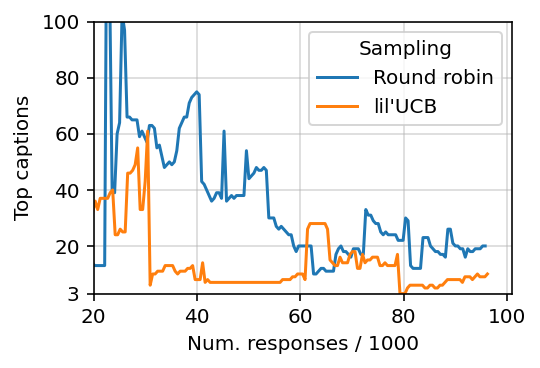

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

alg_names = {"roundrobin": "Round robin", "lilucb": "lil'UCB"}
show["Sampling"] = show["alg"].apply(alg_names.get)

w = 2.5
fig, ax = plt.subplots(figsize=(1.5 * w, w))
ax = sns.lineplot(
    x="n_responses",
    y="possibly_funniest",
    hue="Sampling",
    data=show,
)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x//1000)}"))

# ax.set_yscale('log')
# yticks = sum([[1*10**i, 2*10**i, 5*10**i] for i in [0, 1, 2, 3]], [])
# print(yticks)
# ax.yaxis.set_major_locator(plt.FixedLocator(yticks))
# ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: str(x)))
# ax.set_ylim(20, 1000)
# ax.set_xlim(10_000, None)

ax.set_ylim(3, 100);
yticks = [3] + ax.get_yticks().tolist()
print(yticks)
ax.yaxis.set_major_locator(plt.FixedLocator(yticks))
ax.set_xlim(20_000, None)
# ax.set_xlim(0, None)

ax.grid(alpha=0.5)
ax.set_xlabel("Num. responses / 1000")
ax.set_ylabel("Top captions")
fig.savefig("possibly_funniest.png", dpi=300, bbox_inches="tight", transparent=True)

1


(0.9, 1000.0)

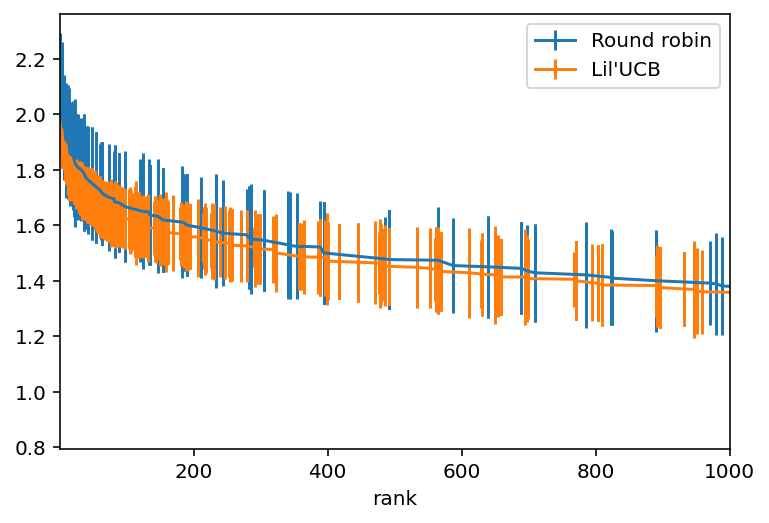

In [10]:
import pandas as pd
from caption_contest_data import summary

df_active = summary("519_summary_LilUCB")
df_passive = summary("519_summary_RoundRobin")

fig, ax = plt.subplots()
static = dict(x="rank", y="score", yerr="precision", ax=ax)
print(df_passive["rank"].min())
# df_passive["rank"] += 1
# df_active["rank"] += 1
df_passive.plot(label="Round robin", **static)
df_active.plot(label="Lil'UCB", **static)
ax.set_xlim(0.9, 1000)
# ax.set_xscale("log")